In [1]:
import pickle
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from emp.metrics.maintenance import multi_process_eprmc, calculate_PRMC
import matplotlib.pyplot as plt

import numpy as np

from functools import partial

import time

import scipy.integrate as integrate
import scipy.stats as st

import multiprocessing
from multiprocessing import Process, Queue


In [2]:
temp = partial(st.lognorm.rvs, s=1.2, scale=6)
temp()

9.670863814087488

In [3]:
with open('data/delme/temp.pkl', 'rb') as r:
    obj = pickle.load(r)
preds = obj['preds']
trues = obj['trues']
cost_rul = obj['cost_rul']
cost_reactive = obj['cost_reactive']
cost_predictive = obj['cost_predictive']
tau = 12
title_font = {'size': 22}
label_font = {'size': 14}

In [15]:
list(map(lambda x: x.kill(), multiprocessing.active_children()))

[]

In [5]:
temp = partial(st.lognorm.cdf, **{'s': 1.2, 'scale': 6})
temp(810)

0.9999782191685734

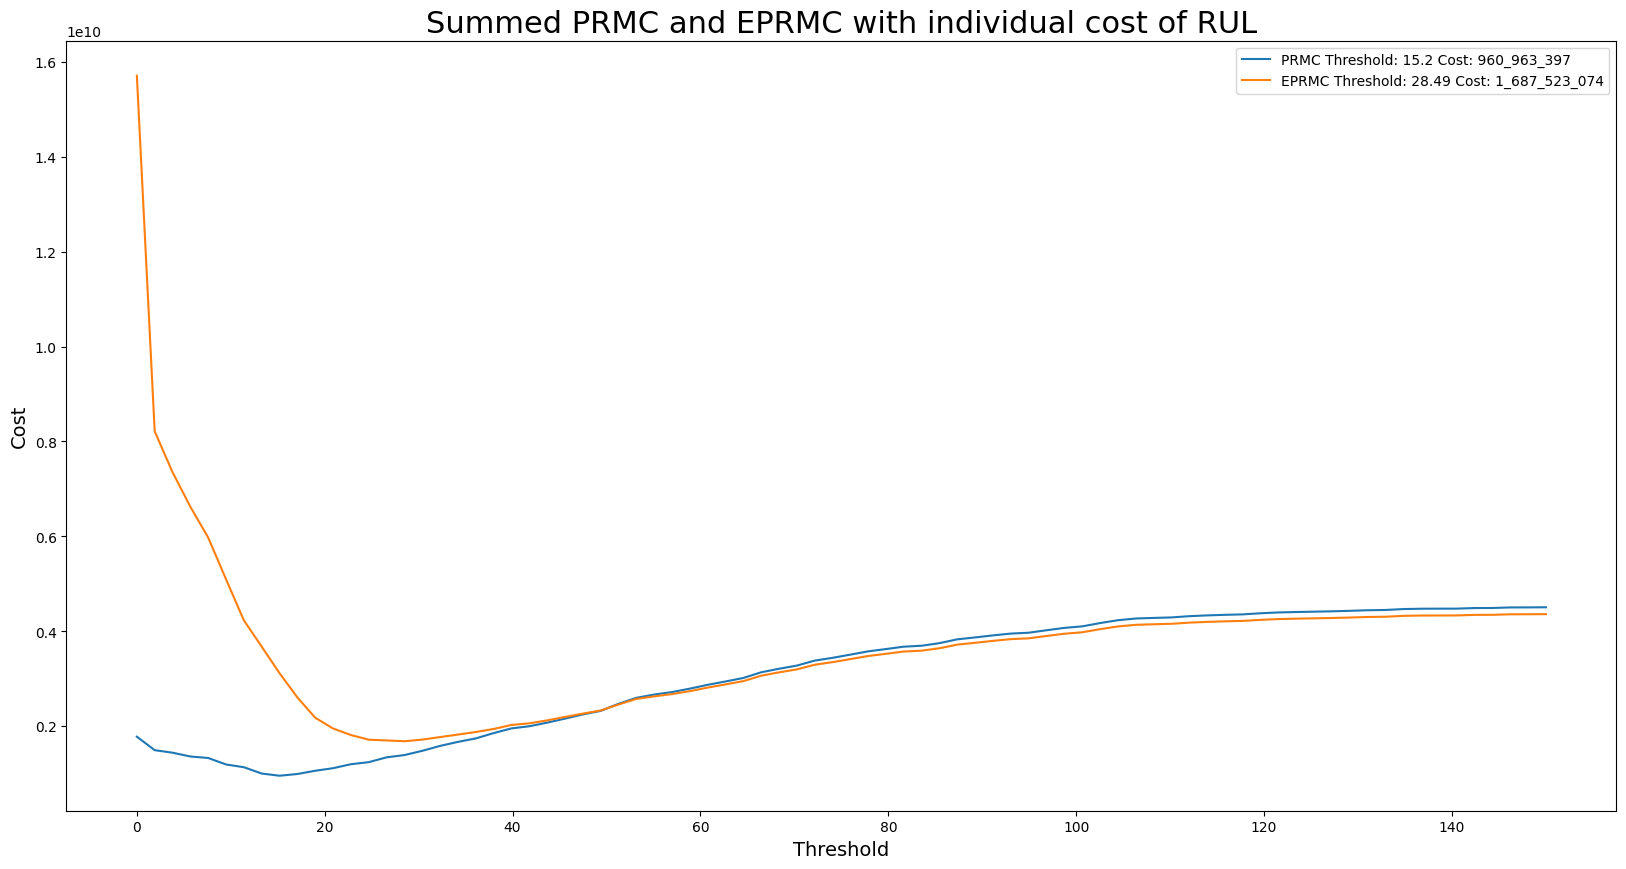

In [12]:
num_thresholds = 80
t = np.linspace(0.01,150,num_thresholds)
plt.figure(figsize=(20,10))

all_costs_to_plot = list()
if type(preds) == list:
    for iter in range(len(preds)):
        costs_to_plot = [np.sum(calculate_PRMC(preds[iter], trues[iter], tau, ti, cost_reactive, cost_predictive, cost_rul[iter])) for ti in t]
        all_costs_to_plot.append(costs_to_plot)
        plt.plot(t, costs_to_plot, label=f'Threshold: {np.argmin(costs_to_plot)} Cost: {round(np.min(costs_to_plot)):_}', linestyle='--')
else:
    costs_to_plot = [np.sum(calculate_PRMC(preds, trues, tau, ti, cost_reactive, cost_predictive, cost_rul)) for ti in t]
    plt.plot(t, costs_to_plot, label=f'PRMC Threshold: {np.round(t[np.argmin(costs_to_plot)], 2)} Cost: {round(np.min(costs_to_plot)):_}')

    costs_to_plot = multi_process_eprmc(t, preds, trues, cost_reactive, cost_predictive, cost_rul)
    plt.plot(t, costs_to_plot, label=f'EPRMC Threshold: {np.round(t[np.argmin(costs_to_plot)], 2)} Cost: {round(np.min(costs_to_plot)):_}')
# plt.plot(t,np.mean(all_costs_to_plot,axis=0),label=f'(AVG) Threshold: {np.argmin(np.mean(all_costs_to_plot,axis=0))} Summed Cost: {round(np.min(np.mean(all_costs_to_plot,axis=0))):_}',linewidth=2.5,linestyle='-')

plt.title('Summed PRMC and EPRMC with individual cost of RUL', fontdict=title_font)
plt.xlabel('Threshold', fontdict=label_font)
plt.ylabel('Cost', fontdict=label_font)
plt.legend()

In [7]:
np.sum(calculate_PRMC(preds, trues, tau, 28.49, cost_reactive, cost_predictive, cost_rul))

1395974212.249132

In [8]:
print(
      f"PRMC threshold: {np.sum(calculate_PRMC(preds,trues,tau,13.3,cost_reactive,cost_predictive,cost_rul)):_}\n"
      + f"EPRMC threshold: {np.sum(calculate_PRMC(preds,trues,tau,30.39,cost_reactive,cost_predictive,cost_rul)):_}\n"
      + f"Run-to-failure: {preds.shape[0] * cost_reactive:_}"
)

PRMC threshold: 1_006_751_934.2256945
EPRMC threshold: 1_485_455_923.6475694
Run-to-failure: 1_783_333_333.3333333


## EPRMC

In [ ]:
num_thresholds = 80
thresholds = np.linspace(0.01, 150, num_thresholds)
plt.figure(figsize=(20,10))

all_costs_to_plot = list()
if type(preds) == list:
    for iter in range(len(preds)):
        costs_to_plot = [np.sum(calculate_PRMC(preds[iter],trues[iter],tau,ti,cost_reactive,cost_predictive,cost_rul[iter])) for ti in t]
        all_costs_to_plot.append(costs_to_plot)
        plt.plot(t,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Cost: {round(np.min(costs_to_plot)):_}',linestyle='--')
else:
    costs_to_plot = multi_process_eprmc(thresholds, preds, trues, cost_reactive, cost_predictive, cost_rul)
    plt.plot(thresholds,costs_to_plot,label=f'Threshold: {np.argmin(costs_to_plot)} Cost: {round(np.min(costs_to_plot)):_}')

# plt.plot(t,np.mean(all_costs_to_plot,axis=0),label=f'(AVG) Threshold: {np.argmin(np.mean(all_costs_to_plot,axis=0))} Summed Cost: {round(np.min(np.mean(all_costs_to_plot,axis=0))):_}',linewidth=2.5,linestyle='-')

plt.title('EPRMC: Summed cost w/ individual cost of RUL\'s',fontdict=title_font)
plt.xlabel('Threshold',fontdict=label_font)
plt.ylabel('Cost',fontdict=label_font)
plt.legend()

NameError: name 'multi_process_eprmc' is not defined

<Figure size 2000x1000 with 0 Axes>

# PLOTLY

In [ ]:
machines = pd.read_csv('data/gold/train.csv')

mach = machines.loc[machines["unit_ID"] == "1-1", :]

In [ ]:
cols = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31',
'W32']

In [ ]:
fig = make_subplots(rows=11, cols=2, subplot_titles=cols, vertical_spacing=0.01)

coords = list()
for row in range(1, 11):
    for col in range(1, 3):
        coords.append((row, col))

for col, coord in zip(cols,coords):
    fig.add_scatter(x=mach['cycles'], y=mach[col], row=coord[0], col=coord[1], showlegend=False)
fig.update_layout(height=4000)
fig.show()

In [ ]:
fig = go.Figure()

for col in cols:
    fig.add_scatter(x=mach['cycles'], y=mach[col])
fig.show()